In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("dark_background")

In [2]:
sys.path.append("../../src")
from lr_tools import lr_calibrate
from models import MLP
from data import gen_rnd_ds
from losses import LinearClassification, SquaredClassification
from block_analysis import block_hessian, curvature_effects

## Helpers

In [3]:
def get_model_ds_loss(nlayer=5, mode="linear"):    
    model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, mode).cuda(device)
    ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                   out_dim, nsamp, device)
    loss_fn = LinearClassification(out_dim)
    return model, ds, loss_fn

## Params

In [4]:
# Model
mode = "linear"
bias = False
nlayer = 5
inp_dim = 10 
out_dim = 10
hid_dim = 100

# Data parameters
nsamp = 100
inp_mean = 0
inp_var = 1

# Others
device = 0
lr = 7

In [9]:
from lr_tools import *
import pandas as pd

def relative_error(a, b, eps=1e-6):
    """
    """
    return abs((a - b) / min(abs(a), abs(b)))

def lr_search(model, ds, loss_fn, low=-5, high=2, nstep=10, log=10):
    """
    """
    lrs = np.linspace(low, high, nstep)
    lrs = 10.**lrs if log else lrs
    errors, hs, HB_sums, deltas = [],[],[],[]
    for lr in lrs:
        H,_ = block_hessian(model, ds, loss_fn, lr)
        delta, h = curvature_effects(model, ds, loss_fn, lr)
        h = h.item()
        HB_sum = H.sum().item()
        error = relative_error(h, HB_sum)
        errors.append(error)
        hs.append(h)
        HB_sums.append(HB_sum)
        deltas.append(delta)

    data = pd.DataFrame(data={"Delta":deltas, "HB_sum":HB_sums, "hs":hs, "error":errors}, index=lrs)
    
    return data

def pprint(data):
    print(f"LR {lr:.2E} \t || Delta={delta:.2E}\t ||Error={rel:.2E}  \t|| hoe={h.item():.2E} \t|| H={H.sum().item():.2E}\t||ratio={ratio:.2E}")
    
def pplot(datas, loss, mode, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    data = datas[datas.loss==loss]
    data = data[data["mode"]==mode]
    for nlayer in nlayers:
        data[data.nlayer==nlayer].error.plot(logx=True,logy=True, ax =ax, label=f"{nlayer} layers")
    if ax is None:
        fig.legend()

### Compute errors

In [10]:
nlayers =  [3, 5, 7, 9, 11, 13, 15]
modes   = ["linear", "relu"]
losses  = {
    "linear":LinearClassification(out_dim),
    "squared":SquaredClassification(out_dim),
    "ce":torch.nn.CrossEntropyLoss()
}

In [7]:
datas = []
for mode in modes:
    for loss_name, loss_fn in losses.items():
        for nlayer in nlayers:
            model, ds, _ = get_model_ds_loss(nlayer, mode)
            data =  lr_search(model, ds, loss_fn, nstep=40)
            data["mode"]  = mode
            data["nlayer"]= nlayer
            data["loss"]  = loss_name
            datas.append(data)

datas = pd.concat(datas)

### Investigate errors

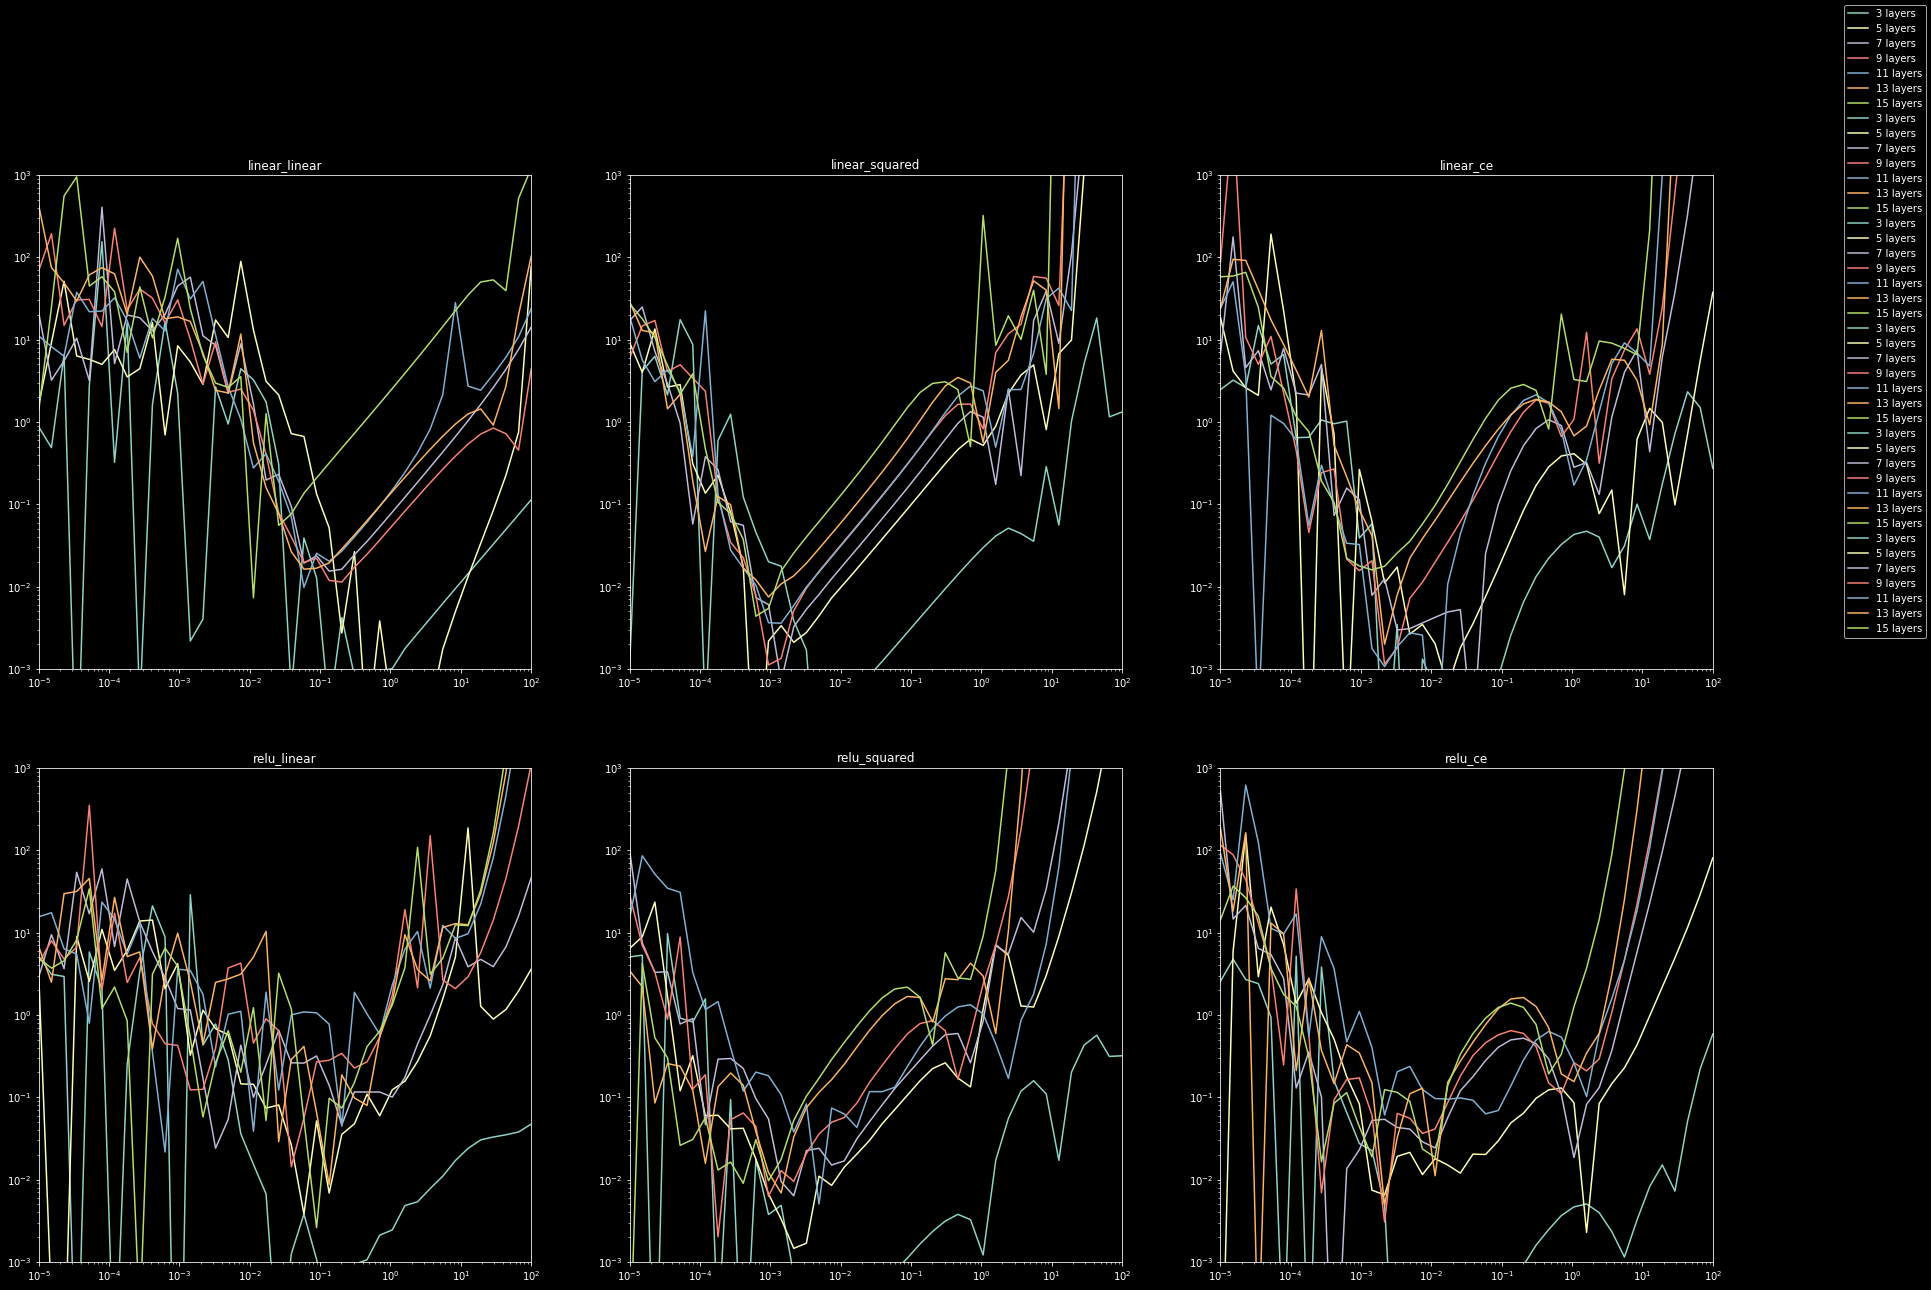

In [20]:
fig, axes = plt.subplots(2,3, figsize=(30,20))

act = "linear"
for i,loss in enumerate(losses):
    ax = axes[0,i]
    pplot(datas, loss, act, ax=ax)
    ax.set_ylim(bottom=10**-3, top=10**3)
    ax.set_title(f"{act}_{loss}")
    
act = "relu"
for i,loss in enumerate(losses):
    ax = axes[1,i]
    pplot(datas, loss, act, ax=ax)
    ax.set_ylim(bottom=10**-3, top=10**3)
    ax.set_title(f"{act}_{loss}")
    
fig.legend()